# Model prototyping 
### Fraud detection engine

A sandbox for prototyping different modelling approaches to identify fraudulent transactions

```Benjamin Jones```


__Tasks carried out:__
* subset the data 
* undersample the majority class 
* encode categorical features
* generate engineered features from EDA insights
* generate cross-validated folds
* trial various different model types
* examine performance metrics
* interpret and plot performance curves, feature importances, learning curves, ROC plots

__Experiments:__ 
* benchmarking
* categorical variable encoding
* sample size variation
* boosting/bagging ensembles
* engineered features
* hyperparameter tuning

__A full summary of the modelling approach can be found in the readme.md.__


### Imports

In [3]:
from pathlib import Path
import logging 
import math

import numpy as np
import pandas as pd

import pycaret.classification as pycc

from src.data.load_raw_data import DataLoader


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Load data with the imported DataLoader class

In [4]:
data_path = Path("../data/raw/transactions.txt")

# instantiate dataloader instance
dl = DataLoader(data_path)
dl.raw_data.head()

INFO:src.data.load_raw_data:file found at path: ..\data\raw\transactions.txt
loading data as json... 
INFO:src.data.load_raw_data:data loaded


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,...,True,,0.00,,,,False,,,False
1,733493772,733493772,5000,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,...,False,,111.33,,,,False,,,False
2,733493772,733493772,5000,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,...,False,,136.08,,,,False,,,False
3,733493772,733493772,5000,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,...,True,,323.48,,,,False,,,False
4,733493772,733493772,5000,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,...,False,,550.82,,,,False,,,False


In [5]:
# transform raw data
date_cols = ['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange']
df = dl.transform_raw_data(date_cols=date_cols, drop_cols=True)
df.head()

INFO:src.data.load_raw_data:transforming data...
INFO:src.data.load_raw_data:coercing columns to datetime format: ['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange']
INFO:src.data.load_raw_data:replacing blanks with np.nan
INFO:src.data.load_raw_data:df.columns dropped: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']

INFO:src.data.load_raw_data:df.columns remaining: 
 ['accountNumber' 'customerId' 'creditLimit' 'availableMoney'
 'transactionDateTime' 'transactionAmount' 'merchantName' 'acqCountry'
 'merchantCountryCode' 'posEntryMode' 'posConditionCode'
 'merchantCategoryCode' 'currentExpDate' 'accountOpenDate'
 'dateOfLastAddressChange' 'cardCVV' 'enteredCVV' 'cardLast4Digits'
 'transactionType' 'isFraud' 'currentBalance' 'cardPresent'
 'expirationDateKeyInMatch']
INFO:src.data.load_raw_data:returning transformed dataframe


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,733493772,5000,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,733493772,5000,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,733493772,5000,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,02,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,733493772,5000,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,02,...,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


In [7]:
# take a small subset of the data to work on a prototype modelling pipeline with
df_sample = df[df['transactionDateTime'] < pd.to_datetime('2016-01-15')]
print(df_sample.shape)

(22249, 23)


In [8]:
# find how many individuals in the True class
len(df_sample[df_sample['isFraud'] == True]['accountNumber'].unique())
## 309

309

In [9]:
# under sample the negative class, don't worry about cross-pollination across accounts for now
df_class_0_under = df_sample[df_sample['isFraud'] == False] \
                                .sample(len(df_sample[df_sample['isFraud'] == True])*2)
len(df_class_0_under)

884

In [10]:
# concatenate with the positive class at a ratio of 2:1
df_class_1 = df_sample[df_sample['isFraud']==True]
df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)
df_under_sample['isFraud'].value_counts()

False    884
True     442
Name: isFraud, dtype: int64

In [11]:
# pycaret requires bool cols to be changed to str first!
df_sample1 = df_under_sample.copy(deep=True)
df_sample1['cardPresent'] = df_sample['cardPresent'].astype(str)
df_sample1['expirationDateKeyInMatch'] = df_sample['expirationDateKeyInMatch'].astype(str)

### Experiment 1 - benchmarking with PyCaret

No modifications to the standard params - just get a benchmark for OOB performance

In [12]:
# pycaret's setup() function carries out a number of common tasks and builds a pipeline performing:
# data sampling, data cleaning and preparation (missing values impute), data type inference, basic feature engineering
# https://pycaret.org/setup/
experiment1 = pycc.setup(df_sample1, 
                         target='isFraud',
                         silent=False,
                         sampling=True,
                         train_size=0.7)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,8567
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(1326, 23)"
4,Missing Values,True
5,Numeric Features,8
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [13]:
# compare_models does exactly that, compares commonly used models to give insight into the best likely estimator type
pycc.compare_models(fold=5, sort='AUC', blacklist=['catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.696200,0.679900,0.352800,0.578700,0.437600,0.244800
1,Light Gradient Boosting Machine,0.681000,0.673400,0.420800,0.531900,0.467600,0.244700
2,Gradient Boosting Classifier,0.697200,0.672600,0.323800,0.583400,0.414000,0.232900
3,Extra Trees Classifier,0.687500,0.661100,0.191000,0.618200,0.289000,0.152800
4,Ada Boost Classifier,0.663800,0.659600,0.366000,0.496900,0.419100,0.191000
5,Random Forest Classifier,0.681100,0.640300,0.194200,0.565600,0.288000,0.141400
6,Linear Discriminant Analysis,0.642200,0.615900,0.404200,0.462400,0.430300,0.171300
7,Decision Tree Classifier,0.610000,0.573200,0.462900,0.427000,0.442600,0.144600
8,K Neighbors Classifier,0.605600,0.562600,0.262300,0.365900,0.305200,0.041500
9,Logistic Regression,0.667000,0.543500,0.000000,0.000000,0.000000,0.000000


We can see that tree-based ensemble algorithms dominate the rankings, possibly in part due to their strong support for categorical variables

### Experiment 2 - encoding categorical variables  

Let's try again, but this time instead of 1-hot encoding our high cardinality variables, we can encode them with more powerful encoding techniques

Note: clustering into orthogonal basis vector space is the best approach but is too computationally expensive. Will use frequency encoding. Would also consider binary encoding but not supported by pycaret at the moment

In [186]:

high_cardinality_features = ['transactionDateTime','merchantName','currentExpDate','accountOpenDate','dateOfLastAddressChange']    
experiment1 = pycc.setup(df_sample1, 
                        target='isFraud', 
                        silent=False, 
                        high_cardinality_features=high_cardinality_features,
                        high_cardinality_method='frequency')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,3793
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(1326, 23)"
4,Missing Values,True
5,Numeric Features,8
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,True
9,High Cardinality Method,frequency


In [187]:
pycc.compare_models(fold=5, sort='AUC', blacklist=['catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Gradient Boosting Classifier,0.688600,0.708900,0.385500,0.543100,0.450000,0.242500
1,Linear Discriminant Analysis,0.699400,0.700000,0.388700,0.569100,0.460500,0.263400
2,Extreme Gradient Boosting,0.685400,0.696300,0.369200,0.541600,0.437800,0.230600
3,Ada Boost Classifier,0.688600,0.691400,0.443800,0.536900,0.484000,0.265100
4,Light Gradient Boosting Machine,0.661700,0.685700,0.379100,0.486700,0.424300,0.191500
5,Extra Trees Classifier,0.683200,0.667500,0.343400,0.541000,0.417000,0.215400
6,Random Forest Classifier,0.670300,0.629900,0.239700,0.508200,0.325500,0.143800
7,Quadratic Discriminant Analysis,0.492500,0.596300,0.649800,0.382200,0.407100,0.056900
8,Decision Tree Classifier,0.621800,0.576300,0.440200,0.433700,0.436300,0.152100
9,K Neighbors Classifier,0.614200,0.557100,0.268700,0.387100,0.314400,0.059800


Here we see some improvement across the board

### Experiment 3 - increase sample size

In [47]:
# first let's undersample again
# TODO: functionise this

df_class_0_under = df[df['isFraud'] == False] \
                                .sample(len(df[df['isFraud'] == True])*2)
# concatenate with the positive class at a ratio of 2:1
df_class_1 = df[df['isFraud']==True]
df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

# pycaret requires bool cols to be changed to str first!
df_under_sample['cardPresent'] = df_under_sample['cardPresent'].astype(str)
df_under_sample['expirationDateKeyInMatch'] = df_under_sample['expirationDateKeyInMatch'].astype(str)

In [147]:
# take a larger data subset (out-of-time) and a holdout set (train set gets later split into train/test by cross validation)
df_train = df_under_sample[df_under_sample['transactionDateTime'] < pd.to_datetime('2016-10-01')]
df_holdout = df_under_sample[df_under_sample['transactionDateTime'] >= pd.to_datetime('2016-10-01')]

print(f'training data: \n{df_train["isFraud"].value_counts()}')
print(f'holdout data: \n{df_holdout["isFraud"].value_counts()}')

training data: 
False    16538
True      8521
Name: isFraud, dtype: int64
holdout data: 
False    6066
True     2781
Name: isFraud, dtype: int64


In [53]:
high_cardinality_features = ['transactionDateTime','merchantName','currentExpDate','accountOpenDate','dateOfLastAddressChange']    
experiment1 = pycc.setup(df_train, 
                        target='isFraud', 
                        silent=True, 
                        high_cardinality_features=high_cardinality_features,
                        high_cardinality_method='frequency')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,6109
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(25059, 23)"
4,Missing Values,True
5,Numeric Features,8
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,True
9,High Cardinality Method,frequency


In [25]:
pycc.compare_models(fold=5, sort='AUC', blacklist=['catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.752000,0.803800,0.505200,0.669700,0.575900,0.405500
1,Extra Trees Classifier,0.737500,0.784400,0.486000,0.639800,0.552400,0.371500
2,Gradient Boosting Classifier,0.735100,0.779100,0.444600,0.650100,0.528000,0.352900
3,Extreme Gradient Boosting,0.732900,0.775700,0.434300,0.648300,0.520100,0.345000
4,Ada Boost Classifier,0.725900,0.764200,0.441200,0.626000,0.517500,0.334000
5,Random Forest Classifier,0.722800,0.753600,0.413500,0.627900,0.498600,0.318100
6,Linear Discriminant Analysis,0.721100,0.750500,0.368200,0.642500,0.468100,0.297500
7,K Neighbors Classifier,0.662500,0.624700,0.366200,0.491700,0.419700,0.188900
8,Decision Tree Classifier,0.661100,0.622500,0.506900,0.491900,0.499200,0.243200
9,Quadratic Discriminant Analysis,0.392500,0.553200,0.998100,0.354100,0.522700,0.060400


Here we see an marked improvement as we increase the size of the training set

In [54]:
lgbm = pycc.create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7595,0.8110,0.5377,0.6874,0.6034,0.4345
1,0.7469,0.8096,0.5008,0.6719,0.5739,0.3992
2,0.7560,0.8116,0.5293,0.6825,0.5962,0.4254
3,0.7389,0.7929,0.5126,0.6469,0.5720,0.3877
4,0.7429,0.7931,0.4858,0.6682,0.5626,0.3869
5,0.7395,0.7936,0.5168,0.6457,0.5741,0.3897
6,0.7463,0.8045,0.5034,0.6682,0.5742,0.3985
7,0.7303,0.7626,0.4698,0.6407,0.5421,0.3574
8,0.7332,0.7828,0.5168,0.6311,0.5683,0.3780
9,0.7605,0.8094,0.5587,0.6796,0.6133,0.4422


In [145]:
# Let's see how it performs against our out-of-time holdout (pycaret does this automatically)
pred_train = pycc.predict_model(lgbm) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.7396,0.7973,0.5047,0.6509,0.5685,0.3863


__Conclusion:__ Good generalisation performance on unseen data

### Experiment 4 - Let's see if we can reduce variance / bias by using an ensemble of lgbms

In [204]:
lgbm_bagged = pycc.ensemble_model(lgbm, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7366,0.7930,0.4545,0.6495,0.5348,0.3590
1,0.7503,0.8084,0.4940,0.6698,0.5686,0.3985
2,0.7526,0.8166,0.5026,0.6720,0.5751,0.4056
3,0.7429,0.7908,0.4940,0.6501,0.5614,0.3843
4,0.7440,0.7934,0.4734,0.6619,0.5520,0.3796
5,0.7491,0.8037,0.4863,0.6714,0.5641,0.3942
6,0.7663,0.8216,0.5154,0.7049,0.5955,0.4366
7,0.7313,0.7920,0.4666,0.6311,0.5365,0.3532
8,0.7387,0.7860,0.4786,0.6458,0.5498,0.3714
9,0.7467,0.8026,0.4683,0.6724,0.5521,0.3833


In [205]:
lgbm_boosted = pycc.ensemble_model(lgbm, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7400,0.7881,0.5369,0.6285,0.5791,0.3927
1,0.7531,0.7982,0.5506,0.6538,0.5978,0.4216
2,0.7674,0.8175,0.5643,0.6826,0.6178,0.4528
3,0.7383,0.7905,0.5455,0.6223,0.5814,0.3922
4,0.7440,0.7897,0.5523,0.6326,0.5897,0.4049
5,0.7429,0.7969,0.5342,0.6367,0.5810,0.3976
6,0.7589,0.8106,0.5599,0.6646,0.6078,0.4355
7,0.7170,0.7825,0.4906,0.5909,0.5361,0.3350
8,0.7324,0.7756,0.5043,0.6216,0.5568,0.3681
9,0.7433,0.7958,0.5009,0.6489,0.5653,0.3874


__Conclusion:__ The ensemble hasn't made a significant difference here

### Investigate plots

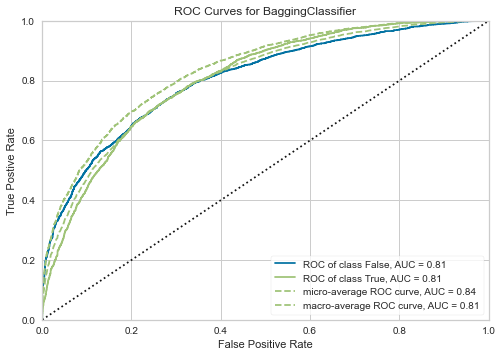

In [208]:
# AUC plot
pycc.plot_model(lgbm_bagged, plot = 'auc')

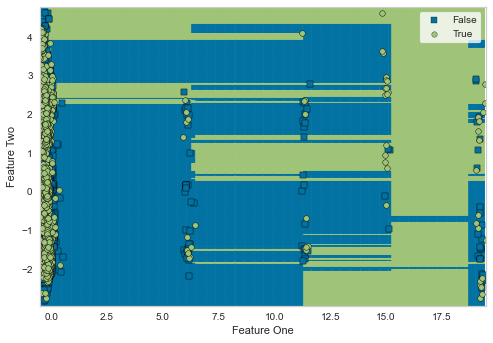

In [211]:
# Decision Boundary
pycc.plot_model(lgbm_bagged, plot = 'boundary')

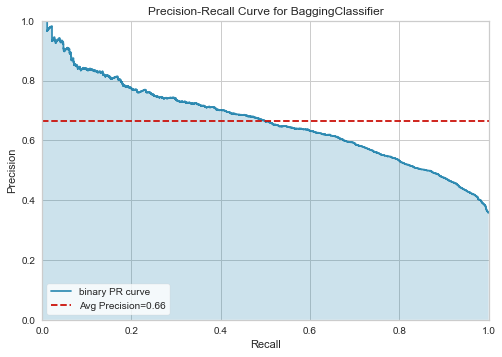

In [209]:
# Precision Recall Curve
pycc.plot_model(lgbm_bagged, plot = 'pr')

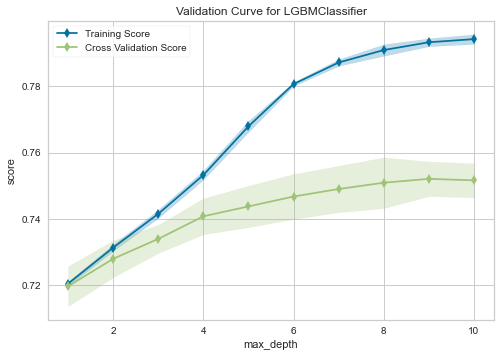

In [28]:
# Validation Curve
pycc.plot_model(lgbm, plot = 'vc')

In [148]:
pycc.evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

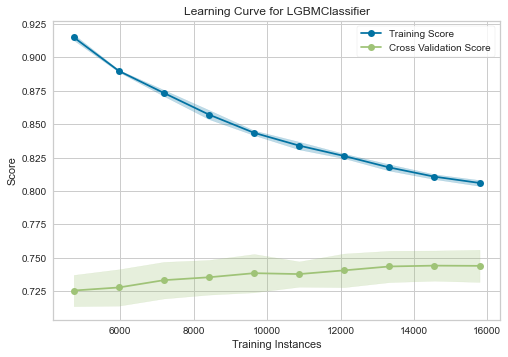

In [149]:
# Learning Curve
pycc.plot_model(lgbm, plot = 'learning')

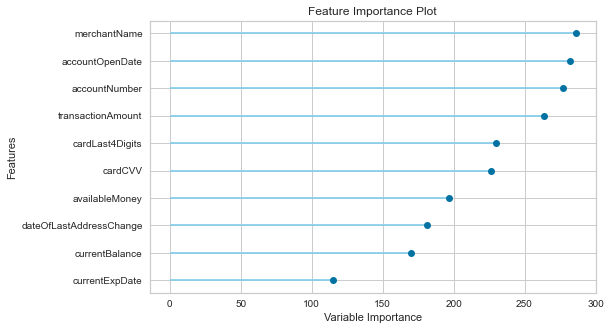

In [218]:
# Feature Importances
pycc.plot_model(lgbm, plot = 'feature')

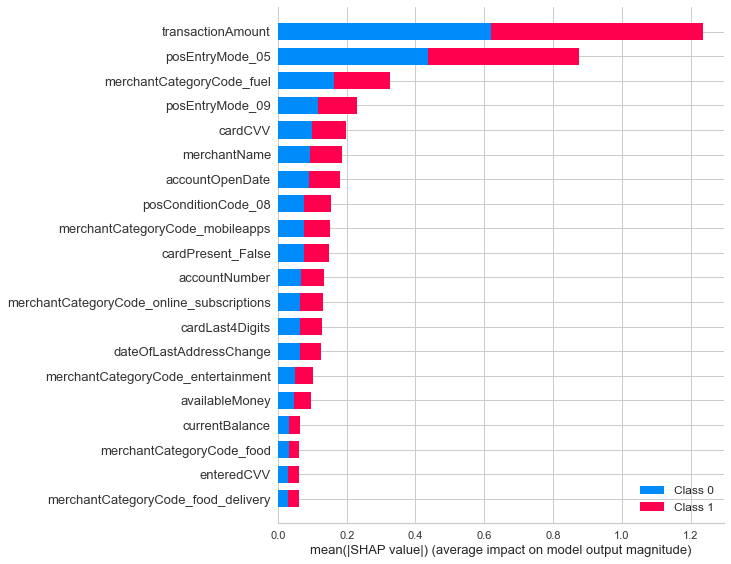

In [224]:
pycc.interpret_model(lgbm)

__Conclusion:__: We can see from the learning curve that we're not data limited, and the model is sufficiently deep on our validation curve, which suggests we may be largely information limited, or our hyperparameters are insufficient

### Experiment 5 - Tune hyperparameters 

In [221]:
# tune the model hyperparameters with a grid search across an empirically known range 
tuned_lgbm = pycc.tune_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7389,0.7837,0.5060,0.6358,0.5635,0.3806
1,0.7389,0.8005,0.4957,0.6394,0.5585,0.3772
2,0.7457,0.8112,0.5026,0.6540,0.5684,0.3925
3,0.7331,0.7827,0.5094,0.6213,0.5598,0.3711
4,0.7320,0.7845,0.4923,0.6239,0.5503,0.3632
5,0.7451,0.7960,0.5086,0.6513,0.5712,0.3937
6,0.7583,0.8090,0.5325,0.6746,0.5952,0.4263
7,0.7170,0.7763,0.4666,0.5965,0.5236,0.3265
8,0.7256,0.7778,0.4751,0.6142,0.5358,0.3455
9,0.7358,0.7951,0.4751,0.6397,0.5453,0.3648


__Conclusion:__ No change by hyperparameter tuning, suggests we need more information to draw correlations

Next step: engineer features

### Feature Engineering

We have a few insights from our EDA for features that we can generate to improve performance 

* Explicitly compute days since start of the dataset since there is a significant shift over time
* Aggregate the merchant names up from individual stores to chains (remove the #12345 in the name)
* Calculate a column that identifies the difference between cardCVV and enteredCVV
* Add columns that convert the transaction amount pences to categorical variables (eg 78.99 -> 99)

In [310]:
# Aggregate the merchant names up from individual stores to chains (remove the #12345 in the name)
df_feat_eng = df.copy()
df_feat_eng['merchantName_short'] = df_feat_eng['merchantName'].apply(lambda row: row.split('#')[0])

In [311]:
# Explicitly turn datetime into a sequential numeric feature since there is a significant shift over time
df_feat_eng['days_since_epoch'] = (df_feat_eng['transactionDateTime'] - pd.to_datetime('1970')).dt.days.astype(float)

In [312]:
# Add a column that dictates whether or not the CVV is the same as the one entered
df_feat_eng['cvv_entered_same'] = df_feat_eng['enteredCVV'].eq(df_feat_eng['cardCVV'])

In [313]:
# Add a column that uses the pence of the transactionAmount as a categorical variable
df_feat_eng['transactionAmount_pence'] = df_feat_eng['transactionAmount'].apply(lambda row: int(math.modf(row)[0]*100))

In [314]:
eng_features = ['merchantName_short', 'days_since_epoch', 'cvv_entered_same', 'transactionAmount_pence']
df_feat_eng[eng_features]

,merchantName_short,days_since_epoch,cvv_entered_same,transactionAmount_pence
0,Lyft,16808.0,True,32
1,Uber,16809.0,True,75
2,Lyft,16811.0,True,40
3,Lyft,16811.0,True,34
4,Lyft,16816.0,True,0
...,...,...,...,...
641909,Apple iTunes,17139.0,True,37
641910,Blue Mountain eCards,17144.0,True,69
641911,Fresh Flowers,17151.0,True,41
641912,abc.com,17154.0,True,30


#### Let's see if these engineered features improve performance

In [315]:
# undersample the 0 population

def undersample(df, target, ratio=[2,1]):
    # undersample the dataframe, default ratio of negative:positive class= 2:1
    size_1_class = len(df[df[target] == True])
    # under sample the negative class
    df_class_0_under = df[df[target] == False] \
                                .sample(size_1_class*ratio[0])
    # concatenate with the positive class
    df_class_1 = df[df[target]==True]
    df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

    print(df_under_sample[target].value_counts())
    
    return df_under_sample

df_model = undersample(df_feat_eng, 'isFraud')

False    22604
True     11302
Name: isFraud, dtype: int64


In [316]:
# pycaret requires bool cols to be changed to str first!
df_model['cardPresent'] = df_model['cardPresent'].astype(str)
df_model['expirationDateKeyInMatch'] = df_model['expirationDateKeyInMatch'].astype(str)
df_model['cvv_entered_same'] = df_model['cvv_entered_same'].astype(str)

df_model

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,merchantName_short,days_since_epoch,cvv_entered_same,transactionAmount_pence
536542,318001076,318001076,50000,9760.92,2016-09-13 10:28:52,68.12,alibaba.com,US,US,02,01,online_retail,03/2020,2015-12-11,2016-08-31,633,633,1789,PURCHASE,False,40239.08,False,False,alibaba.com,17057.0,True,12
103278,251172055,251172055,2500,201.88,2016-08-17 16:40:06,194.39,Ricks Repair,US,US,09,01,auto,06/2027,2015-09-03,2015-09-03,938,938,9880,PURCHASE,False,2298.12,True,False,Ricks Repair,17030.0,True,38
293320,210194932,210194932,20000,19638.41,2016-02-13 00:52:00,221.70,Universe Massage #371648,US,US,05,99,personal care,09/2031,2012-10-25,2012-10-25,304,304,3069,PURCHASE,False,361.59,True,False,Universe Massage,16844.0,True,69
136,733493772,733493772,5000,2623.87,2016-09-27 21:01:54,58.59,Lyft,US,US,09,01,rideshare,04/2029,2014-08-03,2016-06-26,492,492,9184,PURCHASE,False,2376.13,False,False,Lyft,17071.0,True,59
34864,742927928,742927928,5000,3029.35,2016-04-04 03:31:29,87.91,AMC #74121,US,US,05,01,entertainment,08/2029,2007-07-11,2016-02-10,830,830,6392,PURCHASE,False,1970.65,True,False,AMC,16895.0,True,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641627,877651598,877651598,7500,5802.15,2016-11-26 09:23:07,44.27,target.com,US,US,05,01,online_retail,02/2019,2012-01-07,2012-01-07,547,547,3593,PURCHASE,True,1697.85,False,False,target.com,17131.0,True,27
641792,455115932,455115932,50000,34545.80,2016-09-12 00:18:28,12.71,Blue Mountain Online Services,US,US,05,01,online_gifts,04/2023,2011-02-02,2011-02-02,148,148,2521,PURCHASE,True,15454.20,False,False,Blue Mountain Online Services,17056.0,True,71
641812,455115932,455115932,50000,33255.25,2016-10-17 04:27:42,695.87,Fresh Flowers,US,US,09,01,online_gifts,08/2024,2011-02-02,2011-02-02,148,148,2521,PURCHASE,True,16744.75,False,False,Fresh Flowers,17091.0,True,87
641870,186770399,186770399,7500,6448.10,2016-05-19 08:55:28,92.60,Blue Mountain Online Services,US,US,02,01,online_gifts,06/2026,2015-11-04,2015-11-04,127,127,5432,PURCHASE,True,1051.90,False,False,Blue Mountain Online Services,16940.0,True,59


In [335]:
# optional sampling step
sample = False
if sample:
    df_sample = df_model[df_model['transactionDateTime'] < pd.to_datetime('2016-01-10')]
else:
    df_sample = df_model

df_sample['isFraud'].value_counts()


False    22604
True     11302
Name: isFraud, dtype: int64

In [336]:
high_cardinality_features = ['transactionDateTime','merchantName','currentExpDate',
                             'accountOpenDate','dateOfLastAddressChange', 'transactionAmount_pence', 
                             'merchantName_short']    
experiment1 = pycc.setup(df_sample, 
                        target='isFraud', 
                        silent=False,
                        sampling=True,
                        categorical_features=['transactionAmount_pence'],
                        high_cardinality_features=high_cardinality_features,
                        high_cardinality_method='frequency')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5673
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(33906, 27)"
4,Missing Values,True
5,Numeric Features,9
6,Categorical Features,13
7,Ordinal Features,False
8,High Cardinality Features,True
9,High Cardinality Method,frequency


In [337]:
pycc.compare_models(fold=5, sort='AUC', blacklist=['catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.749600,0.800600,0.506300,0.663100,0.574000,0.401200
1,Extra Trees Classifier,0.741300,0.786200,0.463000,0.659800,0.543900,0.371000
2,Gradient Boosting Classifier,0.733100,0.778600,0.442200,0.645900,0.524800,0.348200
3,Extreme Gradient Boosting,0.733800,0.775200,0.441300,0.648200,0.525000,0.349200
4,Ada Boost Classifier,0.721300,0.761300,0.424900,0.620400,0.504100,0.319600
5,Random Forest Classifier,0.722900,0.751700,0.401300,0.633300,0.491200,0.313800
6,Linear Discriminant Analysis,0.718200,0.749400,0.366100,0.634500,0.464100,0.291100
7,K Neighbors Classifier,0.661800,0.621800,0.370000,0.490200,0.421700,0.189200
8,Decision Tree Classifier,0.658600,0.619400,0.501700,0.488200,0.494800,0.237100
9,Quadratic Discriminant Analysis,0.397900,0.551500,0.998600,0.356200,0.525100,0.066300


In [ ]:
lgbm = pycc.create_model('lightgbm')

In [343]:
tuned_lgbm = pycc.tune_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7473,0.7939,0.5322,0.6467,0.5839,0.4049
1,0.7460,0.7978,0.5234,0.6469,0.5786,0.3997
2,0.7578,0.8051,0.5221,0.6770,0.5896,0.4218
3,0.7350,0.7821,0.4747,0.6384,0.5445,0.3634
4,0.7480,0.8011,0.5537,0.6413,0.5943,0.4130
5,0.7691,0.8242,0.5638,0.6872,0.6194,0.4560
6,0.7345,0.7837,0.5221,0.6211,0.5673,0.3779
7,0.7611,0.8090,0.5107,0.6918,0.5876,0.4248
8,0.7585,0.8051,0.5398,0.6714,0.5985,0.4287
9,0.7649,0.8202,0.5436,0.6858,0.6065,0.4420


In [346]:
lgbm_tuned_boosted = pycc.ensemble_model(tuned_lgbm, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7532,0.8022,0.5095,0.6705,0.5790,0.4090
1,0.7527,0.8044,0.5196,0.6650,0.5834,0.4113
2,0.7536,0.8145,0.5019,0.6752,0.5758,0.4074
3,0.7405,0.7967,0.4747,0.6528,0.5497,0.3738
4,0.7560,0.8043,0.5474,0.6621,0.5993,0.4262
5,0.7720,0.8318,0.5461,0.7036,0.6149,0.4566
6,0.7341,0.7866,0.5095,0.6238,0.5609,0.3730
7,0.7619,0.8212,0.5158,0.6915,0.5909,0.4279
8,0.7560,0.8144,0.5133,0.6767,0.5838,0.4157
9,0.7674,0.8236,0.5259,0.7015,0.6012,0.4417


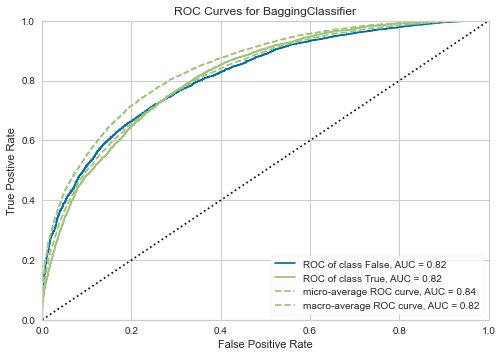

In [350]:
# AUC plot
pycc.plot_model(lgbm_tuned_boosted, plot = 'auc')

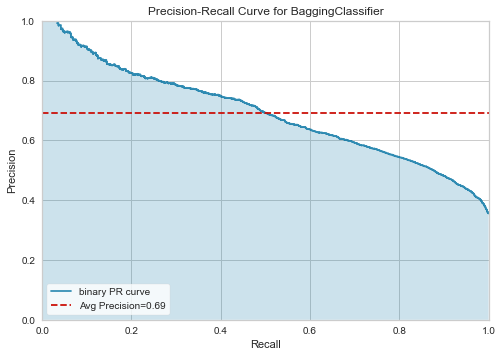

In [351]:
# Precision Recall Curve
pycc.plot_model(lgbm_tuned_boosted, plot = 'pr')

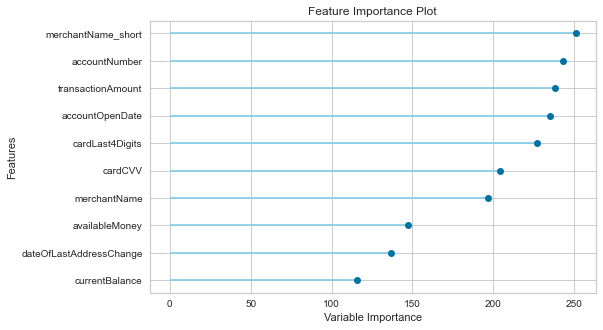

In [356]:
# Feature importances
pycc.plot_model(lgbm, plot = 'feature')

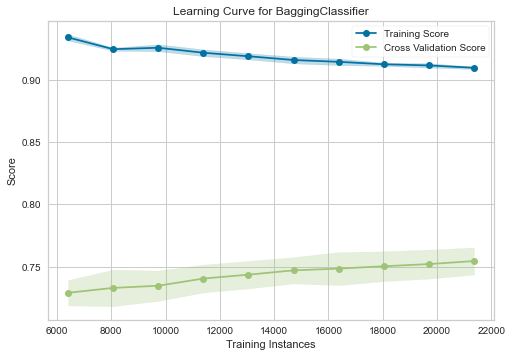

In [357]:
# Learning curves
pycc.plot_model(lgbm_tuned_boosted, plot = 'learning')

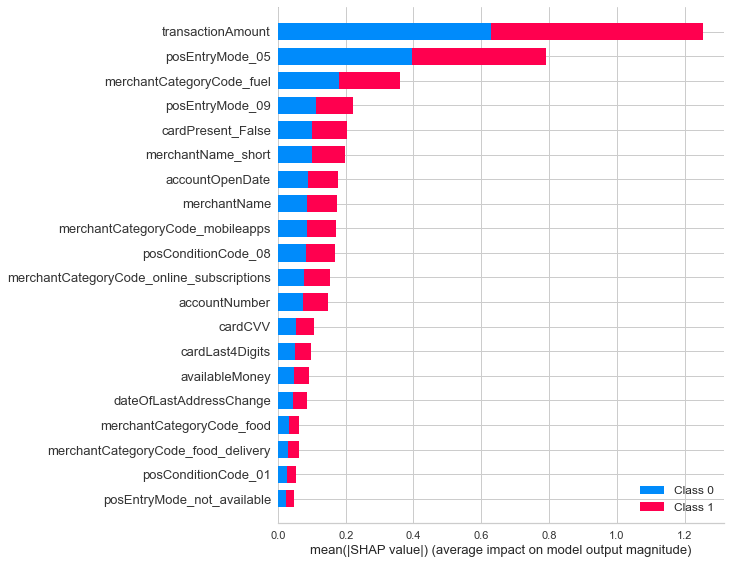

In [341]:
pycc.interpret_model(lgbm)

__Conclusion:__ Limited success with the engineered features, though some features do show on the feature importance graph (such as the aggregated merchantName) and we do see a more interesting learning curve that suggests more data would improve our CV AUC. 

In [155]:
# save the model for later use
pycc.save_model(lgbm, '../models/lgbm_02062020')

Transformation Pipeline and Model Succesfully Saved


### Final Summary:  

* We've built a pipeline in PyCaret to classify fraudulent transactions
* We've attempted a number of experiments to identify which modelling approaches are more successful than others 
* With an iterative improvement process , we've moved from an AUC of ~0.65 to ~0.81

A full summary can be found in the readme.md file of this repository.

#### Further Steps: 

* Attempt more complex models (neural nets in TF for example) for comparison
* Attempt different methods of categorical feature encoding (clustering/ binary)
* Generate more features
    * The model is likely to benefit from additional features that expose relationships it can't see, more EDA needed
* Validate results: at the moment we don't isolate the account number from CV folds and the hold out set (the same accounts can exist in both the training and test sets). We'd need to validate that this assumption is valid for the real world scenario 